# This notebook is about feature engineering with sentiment analysis and classification

#### Load useful libraries and df

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


from tqdm import tqdm

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /Users/janice/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/janice/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
df = pd.read_csv("../data/chatgpt_short_clean_combined_en.csv", 
                 parse_dates=["at", "repliedAt"])

In [4]:
df.shape

(30300, 24)

In [5]:
from transformers import pipeline
#import torch

In [6]:
classifier = pipeline("zero-shot-classification")

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [7]:
#candidate_labels = ["feature evaluation", "praise", "bug report", "feature request", "performance", "usage"]
candidate_labels = ["positive", "neutral", "negative"]
hypothesis_template = "The sentiment of this review is {}."

In [8]:
#candidate_labels = list(category_map.values())
predictedCategories = []
ScoreNegative = []
ScoreNeutral = []
ScorePositive = []

for i in tqdm(range(len(df))): # len(df)
    text = df.iloc[i,]['content']
    res = classifier(text, candidate_labels, hypothesis_template=hypothesis_template, multi_label=True)
    labels = res['labels'] 
    scores = res['scores'] #extracting the scores associated with the labels
    res_dict = {label : score for label,score in zip(labels, scores)}
    sorted_dict = dict(sorted(res_dict.items(), key=lambda x:x[1],reverse = True)) #sorting the dictionary of labels in descending order based on their score
    categories  = next(k for i, (k,v) in enumerate(sorted_dict.items()))

    ScorePositive.append(sorted_dict['positive'])
    ScoreNeutral.append(sorted_dict['neutral'])
    ScoreNegative.append(sorted_dict['negative'])
    predictedCategories.append(categories)

100%|██████████| 30300/30300 [4:44:58<00:00,  1.77it/s]  


In [9]:
df_zero_prep = pd.DataFrame({  'category': predictedCategories, 
                                    'positive_score': ScorePositive, 
                                    'neutral_score': ScoreNeutral, 
                                    'negative_score': ScoreNegative})
df_zero = pd.merge(df, df_zero_prep, left_index=True, right_index=True)

In [10]:
df_zero

,Unnamed: 0,at,score,isEdited,userName,content,Source,reviewId,thumbsUpCount,replyContent,...,at_ym,at_m,at_wd,at_w,detected_language,sentence,category,positive_score,neutral_score,negative_score
0,0,2023-10-30 21:26:19,5,False,Andrea Pepkolaj,the best the best help you cant get you just n...,Apple,NaN,NaN,NaN,...,2023-10,October,Monday,44,en,"['the best.', 'the best help you cant get you ...",positive,0.950930,0.032260,0.132460
1,1,2023-05-29 22:57:48,4,False,gjoncari.jurgen,can't edit a question can't edit a question li...,Apple,NaN,NaN,NaN,...,2023-05,May,Monday,22,en,"['can’t edit a question.', 'can’t edit a quest...",positive,0.976214,0.163357,0.279319
2,2,2023-09-07 20:24:32,5,False,arbin11,arbina. i dont have words of gpt gpt is softwa...,Apple,NaN,NaN,NaN,...,2023-09,September,Thursday,36,en,"['arbina.', 'i dont have words of gpt gpt is s...",neutral,0.067470,0.825078,0.747068
3,3,2023-09-24 23:55:57,5,False,Jonahdervishi88,amazing just amazing and so helpful,Apple,NaN,NaN,NaN,...,2023-09,September,Sunday,38,en,"['amazing.', 'just amazing and so helpful']",positive,0.999669,0.001187,0.000298
4,4,2023-11-04 02:30:31,5,False,Sofia Adil,it's good for me and helpful to me okay,Apple,NaN,NaN,NaN,...,2023-11,November,Saturday,44,en,"['it’s good for me and helpful to me.', 'okay']",positive,0.999462,0.929118,0.000506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30295,30912,2023-07-25 17:47:09,5,NaN,Yeamin Hossain (Limon),first review,Google,6bed36cc-bc58-479e-b395-6644d15adeb8,0.0,NaN,...,2023-07,July,Tuesday,30,en,['first review'],positive,0.816886,0.671854,0.675763
30296,30916,2023-07-25 17:08:33,5,NaN,Sarvesh Soni,first downloaded,Google,2ecc7803-920c-4f95-8b15-db9c7b1caa8a,0.0,NaN,...,2023-07,July,Tuesday,30,en,['first downloader'],positive,0.888082,0.590217,0.632305
30297,30918,2023-07-25 17:15:19,5,NaN,mostafijur rahman,usually app,Google,0530373c-1bfc-45d2-9dec-9fc0bb9cff4d,0.0,NaN,...,2023-07,July,Tuesday,30,en,['usually app'],positive,0.846591,0.450016,0.367502
30298,30920,2023-07-27 17:53:37,5,NaN,asac schrader,hell yeah,Google,09b3f8d3-cd42-4adf-8e61-ca70865fc853,0.0,NaN,...,2023-07,July,Thursday,30,en,['hell yeah'],positive,0.998828,0.054262,0.000806


In [11]:
df_zero.groupby('category').mean('category')

,Unnamed: 0,score,thumbsUpCount,reply,Reviews,at_q,at_w,positive_score,neutral_score,negative_score
category,,,,,,,,,,
negative,9275.847581,2.400061,1.362693,0.045026,1.0,3.029206,32.829784,0.065590,0.323229,0.886153
neutral,9561.534431,3.910180,1.151210,0.014970,1.0,3.091317,33.574850,0.306437,0.641864,0.249562
positive,10986.053300,4.779599,1.176478,0.003643,1.0,3.170613,34.764984,0.960617,0.161463,0.023895


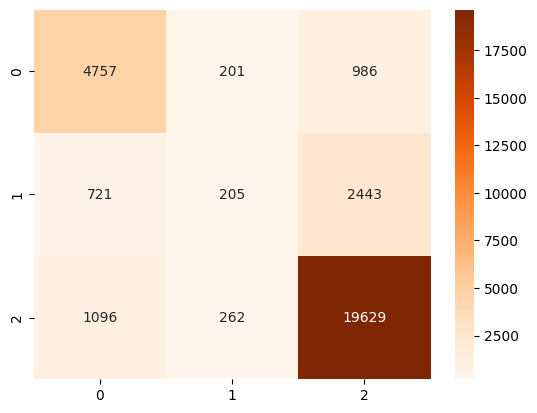

In [12]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


#Confusion matrix using pandas crosstab
conf_matrix = confusion_matrix(df_zero.score_cat, df_zero.category)
sns.heatmap(conf_matrix, annot=True, cmap=plt.cm.Oranges, fmt='g'); 

In [13]:
df_zero.to_csv("../data/ChatGPT-play-reviews-combined_zero.csv", index=False)

## VADER (Valence Aware Dictionary for Sentiment Reasoning)

Good to know:

VADER (Valence Aware Dictionary for Sentiment Reasoning) is a model used for text sentiment analysis that is sensitive to both polarity (positive/negative) and intensity (strength) of emotion. It is available in the NLTK package and can be applied directly to unlabeled text data.

VADER sentimental analysis relies on a dictionary that maps lexical features to emotion intensities known as sentiment scores. The sentiment score of a text can be obtained by summing up the intensity of each word in the text.

For example, Words like ‘love’, ‘enjoy’, ‘happy’, ‘like’ all convey a positive sentiment. Also VADER is intelligent enough to understand the basic context of these words, such as “did not love” as a negative statement. It also understands the emphasis of capitalization and punctuation, such as “ENJOY”

Following code was inspired by the VADER documentation on Git:
https://github.com/cjhutto/vaderSentiment#code-examples

In [14]:
df_zero = pd.read_csv("../data/ChatGPT-play-reviews-combined_zero.csv",
                            encoding="utf-8",
                        )

df_zero.shape

(30300, 28)

In [15]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    #note: depending on how you installed (e.g., using source code download versus pip install), you may need to import like this:
    #from vaderSentiment import SentimentIntensityAnalyzer

In [16]:
from nltk import tokenize

#candidate_labels = list(category_map.values())
vad_cat = []
vad_neg = []
vad_neu = []
vad_pos = []
vad_comp = []

for sentence in tqdm(df_zero['content']):
     sid = SentimentIntensityAnalyzer()
     ss = sid.polarity_scores(sentence)
     for k in sorted(ss):
         vad_cat.append(max(ss, key=ss.get))
         vad_neg.append(ss['neg'])
         vad_neu.append(ss['neu'])
         vad_pos.append(ss['pos'])
         vad_comp.append(ss['compound'])

100%|██████████| 30300/30300 [03:33<00:00, 142.03it/s]


In [17]:
df_vader_prep = pd.DataFrame({ 'vader_cat': vad_cat, 
                               'vader_cmp': vad_comp, 
                                'vader_neg': vad_neg, 
                                'vader_neu': vad_neu, 
                                'vader_pos': vad_pos})
df_vader= pd.merge(df_zero, df_vader_prep, left_index=True, right_index=True)

In [18]:
df_vader.to_csv("../data/ChatGPT-play-reviews-zero-combined_vader.csv", index=False)

In [19]:
df_vader[146:147]

,Unnamed: 0,at,score,isEdited,userName,content,Source,reviewId,thumbsUpCount,replyContent,...,sentence,category,positive_score,neutral_score,negative_score,vader_cat,vader_cmp,vader_neg,vader_neu,vader_pos
146,232,2023-10-11 01:32:55,5,False,374978scott,love it as a curious person i like to ask many...,Apple,NaN,NaN,NaN,...,"['love it.', 'as a curious person i like to as...",positive,0.999283,0.096911,0.000371,compound,0.9164,0.048,0.84,0.113


## Sentiment Analysis using TextBlob

In [20]:
from textblob import TextBlob

Polarity determines the sentiment of the text. Its values lie in [-1,1] where -1 denotes a highly negative sentiment and 1 denotes a highly positive sentiment.

Subjectivity determines whether a text input is factual information or a personal opinion. Its value lies between [0,1] where a value closer to 0 denotes a piece of factual information and a value closer to 1 denotes a personal opinion.

In [21]:
#candidate_labels = list(category_map.values())
blob_polarity = []
blob_subjectivity = []

for sentence in tqdm(df['content']):
     blob_polarity.append(TextBlob(sentence).sentiment.polarity)
     blob_subjectivity.append(TextBlob(sentence).sentiment.subjectivity)

100%|██████████| 30300/30300 [00:08<00:00, 3762.53it/s]


In [22]:
df_blob_prep = pd.DataFrame({ 'blob_polarity': blob_polarity, 
                                    'blob_subjectivity': blob_subjectivity})
df_blob= pd.merge(df_vader, df_blob_prep, left_index=True, right_index=True)

In [23]:
df_blob.to_csv("../data/ChatGPT-play-reviews-combined_sentiment.csv", index=False)

## Sentiment Analysis using Transformer-Based Models

In [24]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [25]:
def strip_len(rev):
    content = rev[0:511]
    return content


In [26]:
df['content'] = df['content'].apply(strip_len)

In [27]:
#candidate_labels = list(category_map.values())
pipe_cat = []
pipe_neg = []
pipe_pos = []

for sentence in tqdm(df['content']):
     res = sentiment_pipeline(sentence)
     if res[0]['label'] == 'POSITIVE':
          pipe_cat.append('POSITIVE')
          pipe_neg.append(1-res[0]['score'])
          pipe_pos.append(res[0]['score'])
     elif res[0]['label'] == 'NEGATIVE':
          pipe_cat.append('NEGATIVE')
          pipe_neg.append(res[0]['score'])
          pipe_pos.append(1-res[0]['score'])

100%|██████████| 30300/30300 [14:47<00:00, 34.12it/s]


In [28]:
df_pipe_prep = pd.DataFrame({ 'pipe_cat': pipe_cat, 
                                    'pipe_neg': pipe_neg, 
                                    'pipe_pos': pipe_pos})

# Load df
df_blob = pd.read_csv(
    "../data/ChatGPT-play-reviews-combined_sentiment.csv"
)

df_pipe= pd.merge(df_blob, df_pipe_prep, left_index=True, right_index=True)

/var/folders/vl/wpx53sjn0nv5cmny0jckrfjr0000gn/T/ipykernel_32944/2669525173.py:6: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_blob = pd.read_csv(


In [29]:
df_pipe

,Unnamed: 0,at,score,isEdited,userName,content,Source,reviewId,thumbsUpCount,replyContent,...,vader_cat,vader_cmp,vader_neg,vader_neu,vader_pos,blob_polarity,blob_subjectivity,pipe_cat,pipe_neg,pipe_pos
0,0,2023-10-30 21:26:19,5,False,Andrea Pepkolaj,the best the best help you cant get you just n...,Apple,NaN,NaN,NaN,...,compound,0.9022,0.0,0.558,0.442,1.000000,0.300000,NEGATIVE,0.865848,0.134152
1,1,2023-05-29 22:57:48,4,False,gjoncari.jurgen,can't edit a question can't edit a question li...,Apple,NaN,NaN,NaN,...,compound,0.9022,0.0,0.558,0.442,0.031111,0.457778,NEGATIVE,0.994539,0.005461
2,2,2023-09-07 20:24:32,5,False,arbin11,arbina. i dont have words of gpt gpt is softwa...,Apple,NaN,NaN,NaN,...,compound,0.9022,0.0,0.558,0.442,0.000000,0.000000,NEGATIVE,0.992920,0.007080
3,3,2023-09-24 23:55:57,5,False,Jonahdervishi88,amazing just amazing and so helpful,Apple,NaN,NaN,NaN,...,compound,0.9022,0.0,0.558,0.442,0.600000,0.900000,POSITIVE,0.000117,0.999883
4,4,2023-11-04 02:30:31,5,False,Sofia Adil,it's good for me and helpful to me okay,Apple,NaN,NaN,NaN,...,neu,0.3612,0.0,0.901,0.099,0.600000,0.550000,POSITIVE,0.000148,0.999852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30295,30912,2023-07-25 17:47:09,5,NaN,Yeamin Hossain (Limon),first review,Google,6bed36cc-bc58-479e-b395-6644d15adeb8,0.0,NaN,...,neu,0.0000,0.0,1.000,0.000,0.250000,0.333333,POSITIVE,0.003007,0.996993
30296,30916,2023-07-25 17:08:33,5,NaN,Sarvesh Soni,first downloaded,Google,2ecc7803-920c-4f95-8b15-db9c7b1caa8a,0.0,NaN,...,compound,0.8658,0.0,0.340,0.660,0.250000,0.333333,POSITIVE,0.110960,0.889040
30297,30918,2023-07-25 17:15:19,5,NaN,mostafijur rahman,usually app,Google,0530373c-1bfc-45d2-9dec-9fc0bb9cff4d,0.0,NaN,...,compound,0.8658,0.0,0.340,0.660,-0.250000,0.250000,POSITIVE,0.028938,0.971062
30298,30920,2023-07-27 17:53:37,5,NaN,asac schrader,hell yeah,Google,09b3f8d3-cd42-4adf-8e61-ca70865fc853,0.0,NaN,...,compound,0.8658,0.0,0.340,0.660,0.000000,0.000000,POSITIVE,0.010897,0.989103


In [34]:
df_pipe.drop(columns=['sentence','Unnamed: 0'], inplace=True, errors='ignore')
df_pipe.to_csv("../data/ChatGPT-play-reviews-combined_sentiment.csv", index=False)

In [35]:
# Load df
df_pipe = pd.read_csv(
    "../data/ChatGPT-play-reviews-combined_sentiment.csv"
)


/var/folders/vl/wpx53sjn0nv5cmny0jckrfjr0000gn/T/ipykernel_32944/2540756791.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pipe = pd.read_csv(


In [37]:
df_pipe

,at,score,isEdited,userName,content,Source,reviewId,thumbsUpCount,replyContent,repliedAt,...,vader_cat,vader_cmp,vader_neg,vader_neu,vader_pos,blob_polarity,blob_subjectivity,pipe_cat,pipe_neg,pipe_pos
0,2023-10-30 21:26:19,5,False,Andrea Pepkolaj,the best the best help you cant get you just n...,Apple,NaN,NaN,NaN,NaN,...,compound,0.9022,0.0,0.558,0.442,1.000000,0.300000,NEGATIVE,0.865848,0.134152
1,2023-05-29 22:57:48,4,False,gjoncari.jurgen,can't edit a question can't edit a question li...,Apple,NaN,NaN,NaN,NaN,...,compound,0.9022,0.0,0.558,0.442,0.031111,0.457778,NEGATIVE,0.994539,0.005461
2,2023-09-07 20:24:32,5,False,arbin11,arbina. i dont have words of gpt gpt is softwa...,Apple,NaN,NaN,NaN,NaN,...,compound,0.9022,0.0,0.558,0.442,0.000000,0.000000,NEGATIVE,0.992920,0.007080
3,2023-09-24 23:55:57,5,False,Jonahdervishi88,amazing just amazing and so helpful,Apple,NaN,NaN,NaN,NaN,...,compound,0.9022,0.0,0.558,0.442,0.600000,0.900000,POSITIVE,0.000117,0.999883
4,2023-11-04 02:30:31,5,False,Sofia Adil,it's good for me and helpful to me okay,Apple,NaN,NaN,NaN,NaN,...,neu,0.3612,0.0,0.901,0.099,0.600000,0.550000,POSITIVE,0.000148,0.999852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30295,2023-07-25 17:47:09,5,NaN,Yeamin Hossain (Limon),first review,Google,6bed36cc-bc58-479e-b395-6644d15adeb8,0.0,NaN,NaN,...,neu,0.0000,0.0,1.000,0.000,0.250000,0.333333,POSITIVE,0.003007,0.996993
30296,2023-07-25 17:08:33,5,NaN,Sarvesh Soni,first downloaded,Google,2ecc7803-920c-4f95-8b15-db9c7b1caa8a,0.0,NaN,NaN,...,compound,0.8658,0.0,0.340,0.660,0.250000,0.333333,POSITIVE,0.110960,0.889040
30297,2023-07-25 17:15:19,5,NaN,mostafijur rahman,usually app,Google,0530373c-1bfc-45d2-9dec-9fc0bb9cff4d,0.0,NaN,NaN,...,compound,0.8658,0.0,0.340,0.660,-0.250000,0.250000,POSITIVE,0.028938,0.971062
30298,2023-07-27 17:53:37,5,NaN,asac schrader,hell yeah,Google,09b3f8d3-cd42-4adf-8e61-ca70865fc853,0.0,NaN,NaN,...,compound,0.8658,0.0,0.340,0.660,0.000000,0.000000,POSITIVE,0.010897,0.989103


In [33]:
df

,Unnamed: 0,at,score,isEdited,userName,content,Source,reviewId,thumbsUpCount,replyContent,...,Original content,score_cat,at_ymd,at_q,at_ym,at_m,at_wd,at_w,detected_language,sentence
0,0,2023-10-30 21:26:19,5,False,Andrea Pepkolaj,the best the best help you cant get you just n...,Apple,NaN,NaN,NaN,...,The best. The best help you cant get you just ...,positive,10/30/23,4,2023-10,October,Monday,44,en,"['the best.', 'the best help you cant get you ..."
1,1,2023-05-29 22:57:48,4,False,gjoncari.jurgen,can't edit a question can't edit a question li...,Apple,NaN,NaN,NaN,...,Can’t edit a question. Can’t edit a question l...,neutral,05/29/23,2,2023-05,May,Monday,22,en,"['can’t edit a question.', 'can’t edit a quest..."
2,2,2023-09-07 20:24:32,5,False,arbin11,arbina. i dont have words of gpt gpt is softwa...,Apple,NaN,NaN,NaN,...,Arbina. I dont have words of Gpt \nGpt is soft...,positive,09/07/23,3,2023-09,September,Thursday,36,en,"['arbina.', 'i dont have words of gpt gpt is s..."
3,3,2023-09-24 23:55:57,5,False,Jonahdervishi88,amazing just amazing and so helpful,Apple,NaN,NaN,NaN,...,Amazing. Just amazing and so helpful,positive,09/24/23,3,2023-09,September,Sunday,38,en,"['amazing.', 'just amazing and so helpful']"
4,4,2023-11-04 02:30:31,5,False,Sofia Adil,it's good for me and helpful to me okay,Apple,NaN,NaN,NaN,...,It’s good for me and helpful to me. Okay,positive,11/04/23,4,2023-11,November,Saturday,44,en,"['it’s good for me and helpful to me.', 'okay']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30295,30912,2023-07-25 17:47:09,5,NaN,Yeamin Hossain (Limon),first review,Google,6bed36cc-bc58-479e-b395-6644d15adeb8,0.0,NaN,...,First Review,positive,07/25/23,3,2023-07,July,Tuesday,30,en,['first review']
30296,30916,2023-07-25 17:08:33,5,NaN,Sarvesh Soni,first downloaded,Google,2ecc7803-920c-4f95-8b15-db9c7b1caa8a,0.0,NaN,...,First downloader,positive,07/25/23,3,2023-07,July,Tuesday,30,en,['first downloader']
30297,30918,2023-07-25 17:15:19,5,NaN,mostafijur rahman,usually app,Google,0530373c-1bfc-45d2-9dec-9fc0bb9cff4d,0.0,NaN,...,Usually app,positive,07/25/23,3,2023-07,July,Tuesday,30,en,['usually app']
30298,30920,2023-07-27 17:53:37,5,NaN,asac schrader,hell yeah,Google,09b3f8d3-cd42-4adf-8e61-ca70865fc853,0.0,NaN,...,Hell yeah,positive,07/27/23,3,2023-07,July,Thursday,30,en,['hell yeah']
